In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

In [27]:
# Load dataset
data = pd.read_csv('parkingLot.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Split entry and exit data
entry_records = data.query("camera_id == 1")
exit_records = data.query("camera_id == 2")
parking_data = entry_records.merge(exit_records, on='vehicle_no', suffixes=('_entry', '_exit'))

# Calculate time spent in minutes
parking_data['time_spent'] = (parking_data['timestamp_exit'] - parking_data['timestamp_entry']).dt.total_seconds() / 60
valid_parking_data = parking_data[parking_data['time_spent'] > 0]
valid_parking_data['date'] = valid_parking_data['timestamp_entry'].dt.date
daily_avg_time = valid_parking_data.groupby(valid_parking_data['date'])['time_spent'].mean().reset_index()
daily_avg_time['date'] = pd.to_datetime(daily_avg_time['date'])
daily_avg_time.set_index('date', inplace=True)

/var/folders/_s/snvdbxhj417_xkdjg8qlyl3m0000gn/T/ipykernel_92377/537354083.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_parking_data['date'] = valid_parking_data['timestamp_entry'].dt.date


In [28]:
first_strat = daily_avg_time.copy()
first_strat['time_spent'] = first_strat['time_spent'].interpolate(method='time')
second_strat = daily_avg_time.copy()
second_strat['time_spent'] = second_strat['time_spent'].fillna(method='ffill')

/var/folders/_s/snvdbxhj417_xkdjg8qlyl3m0000gn/T/ipykernel_92377/2978434721.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  second_strat['time_spent'] = second_strat['time_spent'].fillna(method='ffill')


In [29]:
# Split data into training and testing sets
train1, test1 = first_strat.iloc[:-7], first_strat.iloc[-7:]
train2, test2 = second_strat.iloc[:-7], second_strat.iloc[-7:]

# ARIMA model for first strategy
arima_model1 = ARIMA(train1['time_spent'], order=(5, 1, 0)).fit()
arima_forecast1 = arima_model1.forecast(steps=7)
ets_model1 = ExponentialSmoothing(train1['time_spent'], seasonal='add', seasonal_periods=7).fit()
ets_forecast1 = ets_model1.forecast(steps=7)

# ARIMA model for second strategy
arima_model2 = ARIMA(train2['time_spent'], order=(5, 1, 0)).fit()
arima_forecast2 = arima_model2.forecast(steps=7)
ets_model2 = ExponentialSmoothing(train2['time_spent'], seasonal='add', seasonal_periods=7).fit()
ets_forecast2 = ets_model2.forecast(steps=7)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

In [30]:
mase_arima1 = mean_absolute_error(test1['time_spent'], arima_forecast1) / mean_absolute_error(train1['time_spent'], np.full(len(train1), train1['time_spent'].mean()))
mape_arima1 = np.mean(np.abs((test1['time_spent'] - arima_forecast1) / test1['time_spent'])) * 100

mase_ets1 = mean_absolute_error(test1['time_spent'], ets_forecast1) / mean_absolute_error(train1['time_spent'], np.full(len(train1), train1['time_spent'].mean()))
mape_ets1 = np.mean(np.abs((test1['time_spent'] - ets_forecast1) / test1['time_spent'])) * 100

mase_arima2 = mean_absolute_error(test2['time_spent'], arima_forecast2) / mean_absolute_error(train2['time_spent'], np.full(len(train2), train2['time_spent'].mean()))
mape_arima2 = np.mean(np.abs((test2['time_spent'] - arima_forecast2) / test2['time_spent'])) * 100

mase_ets2 = mean_absolute_error(test2['time_spent'], ets_forecast2) / mean_absolute_error(train2['time_spent'], np.full(len(train2), train2['time_spent'].mean()))
mape_ets2 = np.mean(np.abs((test2['time_spent'] - ets_forecast2) / test2['time_spent'])) * 100


In [31]:
print("Strategy 1 - Interpolation")
print(f"ARIMA - MASE: {mase_arima1}, MAPE: {mape_arima1}")
print(f"ETS - MASE: {mase_ets1}, MAPE: {mape_ets1}")
print("\nStrategy 2 - Forward Fill")
print(f"ARIMA - MASE: {mase_arima2}, MAPE: {mape_arima2}")
print(f"ETS - MASE: {mase_ets2}, MAPE: {mape_ets2}")

Strategy 1 - Interpolation
ARIMA - MASE: 0.08821565512678796, MAPE: 94.39604510723159
ETS - MASE: 0.10913463408387818, MAPE: 130.0738797332031

Strategy 2 - Forward Fill
ARIMA - MASE: 0.08821565512678796, MAPE: 94.39604510723159
ETS - MASE: 0.10913463408387818, MAPE: 130.0738797332031


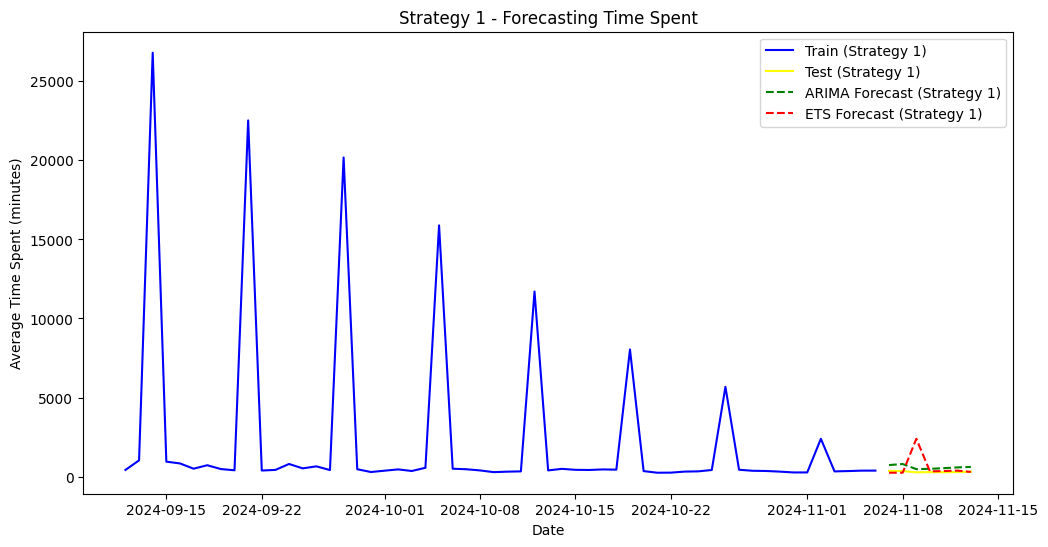

In [32]:
# Plot Strategy 1
plt.figure(figsize=(12, 6))
plt.plot(train1.index, train1['time_spent'], label='Train (Strategy 1)', color='blue')
plt.plot(test1.index, test1['time_spent'], label='Test (Strategy 1)', color='yellow')
plt.plot(test1.index, arima_forecast1, label='ARIMA Forecast (Strategy 1)', linestyle='--', color='green')
plt.plot(test1.index, ets_forecast1, label='ETS Forecast (Strategy 1)', linestyle='--', color='red')
plt.legend()
plt.title('Strategy 1 - Forecasting Time Spent')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (minutes)')
plt.show()

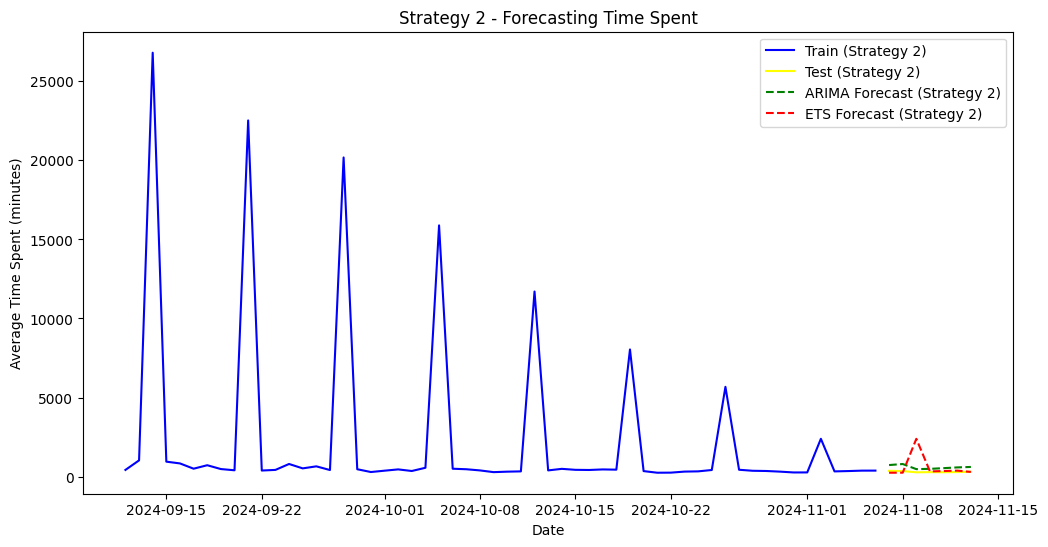

In [33]:
# Plot Strategy 2
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2['time_spent'], label='Train (Strategy 2)', color='blue')
plt.plot(test2.index, test2['time_spent'], label='Test (Strategy 2)', color='yellow')
plt.plot(test2.index, arima_forecast2, label='ARIMA Forecast (Strategy 2)', linestyle='--', color='green')
plt.plot(test2.index, ets_forecast2, label='ETS Forecast (Strategy 2)', linestyle='--', color='red')
plt.legend()
plt.title('Strategy 2 - Forecasting Time Spent')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (minutes)')
plt.show()